In [1]:
from TorchLoop import Train
import pandas as pd
import math
import os
import numpy as np
import torch
import torch.nn as nn
from Rock.Model.MDN_From_Kaggle import mdn as mdn_advance, Mixture, NLLLoss
from Rock.Utils.View import init_weights
import matplotlib.pyplot as plt
import proplot as pplt
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import joblib


In [2]:
input_parameters = [
    'Mass',
    'Radius',
    'Fe_(Mg+Si)',
    'k2',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'CMF',
    'PRS_CMB',
    'TEP_CMB',
]

In [3]:
loop = Train.TorchLoop(batch_size=1024, learning_rate=0.0001984, epoch=150, weight_decay=0.001)

Batch size: 1024, Learning rate:0.0001984, is GPU: True


In [4]:
model = mdn_advance(len(input_parameters), len(output_parameters), 10, 256)
criterion = NLLLoss()
pdf = Mixture()

In [5]:
file_path = 'D:\\Resource\\MRCK_2\\'
nowater_data_frames = []

file_nowater = os.listdir(file_path + 'nowater')
for f in file_nowater:
    tmp = pd.read_table(file_path + '\\' + 'nowater\\' + f, delimiter="\s+", header=None)
    nowater_data_frames.append(tmp)

df_nowater = pd.concat(nowater_data_frames)


file_water = os.listdir(file_path + 'water')
water_data_frames = []
for f in file_water:
    tmp = pd.read_table(file_path + '\\' + 'water\\' + f, delimiter="\s+", header=None)
    water_data_frames.append(tmp)

df_water = pd.concat(water_data_frames)


# combine merged nowater and water data
df_all = pd.concat([df_nowater, df_water])

# rename columns
df_all.columns = ['Mass', 'Radius', 'WMF',
                  'CMF', 'WRF', 'CRF', 'PRS_WMB',
                  'TEP_WMB', 'PRS_CMB', 'TEP_CMB', 'PRS_CEN', 'TEP_CEN',
                  'k2', 'FeMg_mantle', 'SiMg_mantle', 'FeO_mantle']

# reset index
df_all = df_all.reset_index(drop=True)

df_all = df_all.astype(float)

CaMg = 0.06
AlMg = 0.08
wt_frac_S_core = 0.0695     # by mass

mFe = 55.845
mMg = 24.306
mSi = 28.0867
mO = 15.9994
mS = 32.0650
mCa = 40.078
mAl = 26.981

# you can check the FeO_mantle results from the mantle molar ratios FeMg, SiMg, CaMg, AlMg
# The results should be same as the column FeO_mantle
reduced_mantle_mass = df_all['FeMg_mantle'] * (mFe+mO) + df_all['SiMg_mantle'] * (mSi+2.0*mO) + CaMg * (mCa+mO) + AlMg * (mAl+1.5*mO) + (mMg+mO)
FeO_mantle_cal = df_all['FeMg_mantle'] * (mFe+mO) / reduced_mantle_mass

# number of Fe atoms in the core
nFe_core = df_all['CMF'] * (1.0 - wt_frac_S_core) / mFe

# number of Fe atoms in the mantle
nFe_mantle = (1.0 - df_all['CMF'] - df_all['WMF']) * df_all['FeO_mantle'] / (mFe + mO)

# number of Mg atoms in the mantle
nMg_mantle = nFe_mantle / df_all['FeMg_mantle']

# bulk FeMg
FeMg = (nFe_core + nFe_mantle) / nMg_mantle
df_all['FeMg'] = FeMg

# bulk SiMg: there is no Si & Mg in the core
df_all['SiMg'] = df_all['SiMg_mantle']

df_all = df_all[df_all['FeMg']<=40]

df_all["Fe_(Mg+Si)"] = df_all["FeMg"]/(df_all["SiMg"] + 1)

df_all["MRF"] = 1 - df_all["WRF"] - df_all["CRF"]

In [6]:
t_loader, v_loader, test_x, test_y, s_x, s_y = loop.load_data(df_all, input_parameters, output_parameters, train_size=0.9, val_size=0.05, test_size= 0.05)

In [8]:
t_l, v_l, val_r2, train_r2, mse = loop.fit_for_MDN(t_loader, v_loader, criterion, model=model, mixture=pdf, warmup_epoch=5)

module.root_layer.0.weight : torch.Size([256, 4])
module.root_layer.0.bias : torch.Size([256])
module.root_layer.2.weight : torch.Size([256, 256])
module.root_layer.2.bias : torch.Size([256])
module.root_layer.4.weight : torch.Size([256, 256])
module.root_layer.4.bias : torch.Size([256])
module.pi.0.weight : torch.Size([256, 256])
module.pi.0.bias : torch.Size([256])
module.pi.2.weight : torch.Size([10, 256])
module.pi.2.bias : torch.Size([10])
module.mu.0.weight : torch.Size([256, 256])
module.mu.0.bias : torch.Size([256])
module.mu.2.weight : torch.Size([60, 256])
module.mu.2.bias : torch.Size([60])
module.sigma.0.weight : torch.Size([256, 256])
module.sigma.0.bias : torch.Size([256])
module.sigma.2.weight : torch.Size([60, 256])
module.sigma.2.bias : torch.Size([60])


  0%|          | 0/3830 [00:00<?, ?batch/s]E:\anaconda\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch 1 Validating: 100%|██████████| 213/213 [00:03<00:00, 65.65batch/s, loss_avg=-16.7610, loss_val=-16.7096, mse=0.0309, r2=0.3984] 


Epoch 2 Validating: 100%|██████████| 213/213 [00:03<00:00, 66.33batch/s, loss_avg=-20.4007, loss_val=-20.4276, mse=0.0105, r2=0.7941] 


Epoch 3 Validating: 100%|██████████| 213/213 [00:02<00:00, 72.72batch/s, loss_avg=-21.7531, loss_val=-21.7226, mse=0.0068, r2=0.8646] 


Epoch 4 Validating: 100%|██████████| 213/213 [00:03<00:00, 54.20batch/s, loss_avg=-22.8992, loss_val=-22.9292, mse=0.0056, r2=0.8870] 


Epoch 5 Validating: 100%|██████████| 213/213 [00:03<00:00, 68.21batch/s, loss_avg=-23.5602, loss_val=-23.6101, mse=0.0049, r2=0.9014] 


Epoch 6 Validating: 100%|██████████| 213/213 [00:02<00:00, 73.95batch/s, loss_avg=-23.8842, loss_val=-23.8776, mse=0.0042, r2=0.9154] 


Save Best model: R2:0.9154, Loss Avg:-23.8842


Epoch 7 Validating: 100%|██████████| 213/213 [00:04<00:00, 51.77batch/s, loss_avg=-24.3877, loss_val=-24.2871, mse=0.0035, r2=0.9274] 


Save Best model: R2:0.9274, Loss Avg:-24.3877


Epoch 8 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.83batch/s, loss_avg=-24.9195, loss_val=-24.8704, mse=0.0025, r2=0.9477] 


Save Best model: R2:0.9477, Loss Avg:-24.9195


Epoch 9 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.47batch/s, loss_avg=-25.9489, loss_val=-25.8916, mse=0.0018, r2=0.9623] 


Save Best model: R2:0.9623, Loss Avg:-25.9489


Epoch 10 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.72batch/s, loss_avg=-24.4534, loss_val=-24.4288, mse=0.0015, r2=0.9673] 


Save Best model: R2:0.9673, Loss Avg:-24.4534


Epoch 11 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.53batch/s, loss_avg=-26.1376, loss_val=-26.0828, mse=0.0013, r2=0.9724] 


Save Best model: R2:0.9724, Loss Avg:-26.1376


Epoch 12 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.88batch/s, loss_avg=-25.1987, loss_val=-25.1157, mse=0.0012, r2=0.9746] 


Save Best model: R2:0.9746, Loss Avg:-25.1987


Epoch 13 Validating: 100%|██████████| 213/213 [00:03<00:00, 60.35batch/s, loss_avg=-26.3115, loss_val=-26.3402, mse=0.0011, r2=0.9766] 


Save Best model: R2:0.9766, Loss Avg:-26.3115


Epoch 14 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.97batch/s, loss_avg=-27.9895, loss_val=-27.9509, mse=0.0009, r2=0.9797] 


Save Best model: R2:0.9797, Loss Avg:-27.9895


Epoch 15 Validating: 100%|██████████| 213/213 [00:04<00:00, 52.85batch/s, loss_avg=-25.8765, loss_val=-25.8437, mse=0.0010, r2=0.9786] 


Epoch 16 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.56batch/s, loss_avg=-28.1898, loss_val=-28.2015, mse=0.0008, r2=0.9827] 


Save Best model: R2:0.9827, Loss Avg:-28.1898


Epoch 17 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.89batch/s, loss_avg=-27.8870, loss_val=-27.8832, mse=0.0007, r2=0.9837] 


Save Best model: R2:0.9837, Loss Avg:-27.8870


Epoch 18 Validating: 100%|██████████| 213/213 [00:02<00:00, 71.22batch/s, loss_avg=-27.6836, loss_val=-27.6345, mse=0.0008, r2=0.9836] 


Epoch 19 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.22batch/s, loss_avg=-27.6595, loss_val=-27.6330, mse=0.0007, r2=0.9851] 


Save Best model: R2:0.9851, Loss Avg:-27.6595


Epoch 20 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.80batch/s, loss_avg=-28.0999, loss_val=-28.0958, mse=0.0008, r2=0.9824] 


Epoch 21 Validating: 100%|██████████| 213/213 [00:03<00:00, 62.06batch/s, loss_avg=-27.8824, loss_val=-27.8377, mse=0.0006, r2=0.9859] 


Save Best model: R2:0.9859, Loss Avg:-27.8824


Epoch 22 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.09batch/s, loss_avg=-27.3503, loss_val=-27.2063, mse=0.0007, r2=0.9853] 


Epoch 23 Validating: 100%|██████████| 213/213 [00:03<00:00, 60.23batch/s, loss_avg=-27.2796, loss_val=-27.2239, mse=0.0007, r2=0.9841] 


Epoch 24 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.87batch/s, loss_avg=-28.0635, loss_val=-27.9691, mse=0.0007, r2=0.9843] 


Epoch 25 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.45batch/s, loss_avg=-29.1962, loss_val=-29.0883, mse=0.0006, r2=0.9863] 


Save Best model: R2:0.9863, Loss Avg:-29.1962


Epoch 26 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.74batch/s, loss_avg=-29.2867, loss_val=-29.2435, mse=0.0006, r2=0.9857] 


Epoch 27 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.11batch/s, loss_avg=-26.4641, loss_val=-26.3954, mse=0.0008, r2=0.9826] 


Epoch 28 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.27batch/s, loss_avg=-27.7373, loss_val=-27.7174, mse=0.0007, r2=0.9838] 


Epoch 29 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.64batch/s, loss_avg=-27.2396, loss_val=-27.2314, mse=0.0006, r2=0.9869] 


Save Best model: R2:0.9869, Loss Avg:-27.2396


Epoch 30 Validating: 100%|██████████| 213/213 [00:03<00:00, 61.35batch/s, loss_avg=-26.5442, loss_val=-26.5208, mse=0.0008, r2=0.9836] 


Epoch 31 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.54batch/s, loss_avg=-26.8765, loss_val=-26.8518, mse=0.0008, r2=0.9821] 


Epoch 32 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.95batch/s, loss_avg=-27.9914, loss_val=-28.0080, mse=0.0006, r2=0.9875] 


Save Best model: R2:0.9875, Loss Avg:-27.9914


Epoch 33 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.89batch/s, loss_avg=-26.6239, loss_val=-26.4889, mse=0.0007, r2=0.9839] 


Epoch 34 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.66batch/s, loss_avg=-28.8327, loss_val=-28.7826, mse=0.0006, r2=0.9865] 


Epoch 35 Validating: 100%|██████████| 213/213 [00:03<00:00, 54.06batch/s, loss_avg=-28.4542, loss_val=-28.3867, mse=0.0006, r2=0.9874] 


Epoch 36 Validating: 100%|██████████| 213/213 [00:03<00:00, 54.57batch/s, loss_avg=-29.2340, loss_val=-29.2445, mse=0.0005, r2=0.9881] 


Save Best model: R2:0.9881, Loss Avg:-29.2340


Epoch 37 Validating: 100%|██████████| 213/213 [00:03<00:00, 63.75batch/s, loss_avg=-29.0806, loss_val=-29.0267, mse=0.0006, r2=0.9878] 


Epoch 38 Validating: 100%|██████████| 213/213 [00:03<00:00, 60.00batch/s, loss_avg=-28.8733, loss_val=-28.8775, mse=0.0006, r2=0.9878] 


Epoch 39 Validating: 100%|██████████| 213/213 [00:03<00:00, 70.34batch/s, loss_avg=-30.0865, loss_val=-29.9946, mse=0.0005, r2=0.9889] 


Save Best model: R2:0.9889, Loss Avg:-30.0865


Epoch 40 Validating: 100%|██████████| 213/213 [00:03<00:00, 64.72batch/s, loss_avg=-27.6576, loss_val=-27.5679, mse=0.0007, r2=0.9851] 


Epoch 41 Validating: 100%|██████████| 213/213 [00:03<00:00, 70.81batch/s, loss_avg=-30.4376, loss_val=-30.3816, mse=0.0004, r2=0.9900] 


Save Best model: R2:0.9900, Loss Avg:-30.4376


Epoch 42 Validating: 100%|██████████| 213/213 [00:02<00:00, 71.33batch/s, loss_avg=-30.1991, loss_val=-30.1075, mse=0.0005, r2=0.9883] 


Epoch 43 Validating: 100%|██████████| 213/213 [00:03<00:00, 69.64batch/s, loss_avg=-29.4123, loss_val=-29.3329, mse=0.0006, r2=0.9871] 


Epoch 44 Validating: 100%|██████████| 213/213 [00:03<00:00, 69.21batch/s, loss_avg=-30.5915, loss_val=-30.5286, mse=0.0005, r2=0.9894] 


Epoch 45 Validating: 100%|██████████| 213/213 [00:02<00:00, 71.08batch/s, loss_avg=-30.3152, loss_val=-30.3460, mse=0.0005, r2=0.9898] 


Epoch 46 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.92batch/s, loss_avg=-26.6443, loss_val=-26.6612, mse=0.0006, r2=0.9870] 


Epoch 47 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.95batch/s, loss_avg=-26.0013, loss_val=-25.9937, mse=0.0006, r2=0.9873] 


Epoch 48 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.22batch/s, loss_avg=-29.2793, loss_val=-29.1856, mse=0.0004, r2=0.9904] 


Save Best model: R2:0.9904, Loss Avg:-29.2793


Epoch 49 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.01batch/s, loss_avg=-28.4050, loss_val=-28.5047, mse=0.0004, r2=0.9916] 


Save Best model: R2:0.9916, Loss Avg:-28.4050


Epoch 50 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.50batch/s, loss_avg=-30.5773, loss_val=-30.5576, mse=0.0004, r2=0.9909] 


Epoch 51 Validating: 100%|██████████| 213/213 [00:03<00:00, 60.56batch/s, loss_avg=-27.1852, loss_val=-27.4587, mse=0.0005, r2=0.9899] 


Epoch 52 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.17batch/s, loss_avg=-30.6435, loss_val=-30.5217, mse=0.0004, r2=0.9907] 


Epoch 53 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.61batch/s, loss_avg=-28.2689, loss_val=-28.2142, mse=0.0004, r2=0.9913] 


Epoch 54 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.37batch/s, loss_avg=-30.4547, loss_val=-30.4603, mse=0.0004, r2=0.9915] 


Epoch 55 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.98batch/s, loss_avg=-30.9160, loss_val=-30.8861, mse=0.0004, r2=0.9912] 


Epoch 56 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.02batch/s, loss_avg=-29.0303, loss_val=-28.9991, mse=0.0005, r2=0.9899] 


Epoch 57 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.99batch/s, loss_avg=-30.8372, loss_val=-30.7786, mse=0.0004, r2=0.9918] 


Save Best model: R2:0.9918, Loss Avg:-30.8372


Epoch 58 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.42batch/s, loss_avg=-29.2136, loss_val=-29.1307, mse=0.0004, r2=0.9915] 


Epoch 59 Validating: 100%|██████████| 213/213 [00:03<00:00, 69.91batch/s, loss_avg=-29.8343, loss_val=-29.8379, mse=0.0004, r2=0.9906] 


Epoch 60 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.11batch/s, loss_avg=-30.8448, loss_val=-30.7825, mse=0.0004, r2=0.9906] 


Epoch 61 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.49batch/s, loss_avg=-29.0874, loss_val=-29.1160, mse=0.0004, r2=0.9913] 


Epoch 62 Validating: 100%|██████████| 213/213 [00:03<00:00, 61.30batch/s, loss_avg=-30.6406, loss_val=-30.6300, mse=0.0004, r2=0.9919] 


Save Best model: R2:0.9919, Loss Avg:-30.6406


Epoch 63 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.78batch/s, loss_avg=-29.9982, loss_val=-29.9252, mse=0.0004, r2=0.9911] 


Epoch 64 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.89batch/s, loss_avg=-28.8557, loss_val=-28.9225, mse=0.0005, r2=0.9900] 


Epoch 65 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.21batch/s, loss_avg=-28.5579, loss_val=-28.4859, mse=0.0005, r2=0.9883] 


Epoch 66 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.16batch/s, loss_avg=-30.6923, loss_val=-30.7538, mse=0.0004, r2=0.9920] 


Save Best model: R2:0.9920, Loss Avg:-30.6923


Epoch 67 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.73batch/s, loss_avg=-27.4806, loss_val=-27.3832, mse=0.0004, r2=0.9912] 


Epoch 68 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.95batch/s, loss_avg=-31.6269, loss_val=-31.5605, mse=0.0003, r2=0.9925] 


Save Best model: R2:0.9925, Loss Avg:-31.6269


Epoch 69 Validating: 100%|██████████| 213/213 [00:04<00:00, 52.33batch/s, loss_avg=-29.4600, loss_val=-29.4758, mse=0.0004, r2=0.9913] 


Epoch 70 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.29batch/s, loss_avg=-22.6285, loss_val=-22.6148, mse=0.0006, r2=0.9877] 


Epoch 71 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.54batch/s, loss_avg=-30.1222, loss_val=-30.0661, mse=0.0004, r2=0.9916] 


Epoch 72 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.69batch/s, loss_avg=-28.5091, loss_val=-28.4723, mse=0.0004, r2=0.9907] 


Epoch 73 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.48batch/s, loss_avg=-23.4212, loss_val=-23.4577, mse=0.0008, r2=0.9817] 


Epoch 74 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.81batch/s, loss_avg=-30.0730, loss_val=-29.8722, mse=0.0003, r2=0.9923] 


Epoch 75 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.99batch/s, loss_avg=-30.7206, loss_val=-30.7445, mse=0.0003, r2=0.9928] 


Save Best model: R2:0.9928, Loss Avg:-30.7206


Epoch 76 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.49batch/s, loss_avg=-31.8116, loss_val=-31.6903, mse=0.0003, r2=0.9929] 


Save Best model: R2:0.9929, Loss Avg:-31.8116


Epoch 77 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.34batch/s, loss_avg=-31.7872, loss_val=-31.7179, mse=0.0003, r2=0.9923] 


Epoch 78 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.87batch/s, loss_avg=-31.3613, loss_val=-31.3899, mse=0.0003, r2=0.9927] 


Epoch 79 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.49batch/s, loss_avg=-32.5498, loss_val=-32.4614, mse=0.0003, r2=0.9932] 


Save Best model: R2:0.9932, Loss Avg:-32.5498


Epoch 80 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.88batch/s, loss_avg=-29.9649, loss_val=-29.9207, mse=0.0004, r2=0.9912] 


Epoch 81 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.66batch/s, loss_avg=-31.8976, loss_val=-31.8888, mse=0.0003, r2=0.9924] 


Epoch 82 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.02batch/s, loss_avg=-31.8198, loss_val=-31.7049, mse=0.0003, r2=0.9928] 


Epoch 83 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.02batch/s, loss_avg=-30.7033, loss_val=-30.6828, mse=0.0004, r2=0.9918] 


Epoch 84 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.34batch/s, loss_avg=-32.1776, loss_val=-32.1852, mse=0.0003, r2=0.9934] 


Save Best model: R2:0.9934, Loss Avg:-32.1776


Epoch 85 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.97batch/s, loss_avg=-32.1967, loss_val=-32.1176, mse=0.0003, r2=0.9931] 


Epoch 86 Validating: 100%|██████████| 213/213 [00:03<00:00, 55.65batch/s, loss_avg=-31.4798, loss_val=-31.3990, mse=0.0003, r2=0.9932] 


Epoch 87 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.73batch/s, loss_avg=-31.8350, loss_val=-31.8205, mse=0.0003, r2=0.9930] 


Epoch 88 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.28batch/s, loss_avg=-31.1305, loss_val=-31.0120, mse=0.0003, r2=0.9928] 


Epoch 89 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.23batch/s, loss_avg=-29.6825, loss_val=-29.6434, mse=0.0006, r2=0.9865] 


Epoch 90 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.96batch/s, loss_avg=-31.2824, loss_val=-31.2091, mse=0.0003, r2=0.9931] 


Epoch 91 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.27batch/s, loss_avg=-30.2140, loss_val=-30.2671, mse=0.0003, r2=0.9923] 


Epoch 92 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.73batch/s, loss_avg=-31.9998, loss_val=-31.9180, mse=0.0003, r2=0.9934] 


Epoch 93 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.06batch/s, loss_avg=-31.5549, loss_val=-31.5343, mse=0.0003, r2=0.9935] 


Save Best model: R2:0.9935, Loss Avg:-31.5549


Epoch 94 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.81batch/s, loss_avg=-24.4963, loss_val=-24.4230, mse=0.0005, r2=0.9891] 


Epoch 95 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.32batch/s, loss_avg=-32.8906, loss_val=-32.8731, mse=0.0003, r2=0.9939] 


Save Best model: R2:0.9939, Loss Avg:-32.8906


Epoch 96 Validating: 100%|██████████| 213/213 [00:03<00:00, 60.90batch/s, loss_avg=-32.8682, loss_val=-32.8625, mse=0.0003, r2=0.9936] 


Epoch 97 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.85batch/s, loss_avg=-32.4595, loss_val=-32.2554, mse=0.0003, r2=0.9940] 


Save Best model: R2:0.9940, Loss Avg:-32.4595


Epoch 98 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.78batch/s, loss_avg=-29.0781, loss_val=-29.1422, mse=0.0003, r2=0.9926] 


Epoch 99 Validating: 100%|██████████| 213/213 [00:03<00:00, 59.13batch/s, loss_avg=-30.2246, loss_val=-30.2046, mse=0.0004, r2=0.9906] 


Epoch 100 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.74batch/s, loss_avg=-32.2695, loss_val=-32.2309, mse=0.0003, r2=0.9937] 


Epoch 101 Validating: 100%|██████████| 213/213 [00:02<00:00, 73.32batch/s, loss_avg=-29.2005, loss_val=-29.1014, mse=0.0003, r2=0.9933] 


Epoch 102 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.34batch/s, loss_avg=-32.5321, loss_val=-32.4923, mse=0.0003, r2=0.9937] 


Epoch 103 Validating: 100%|██████████| 213/213 [00:02<00:00, 74.92batch/s, loss_avg=-33.0781, loss_val=-33.0647, mse=0.0002, r2=0.9946] 


Save Best model: R2:0.9946, Loss Avg:-33.0781


Epoch 104 Validating: 100%|██████████| 213/213 [00:03<00:00, 57.30batch/s, loss_avg=-31.6126, loss_val=-31.6043, mse=0.0003, r2=0.9933] 


Epoch 105 Validating: 100%|██████████| 213/213 [00:03<00:00, 56.71batch/s, loss_avg=-33.3188, loss_val=-33.2604, mse=0.0003, r2=0.9941] 


Epoch 106 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.96batch/s, loss_avg=-31.0299, loss_val=-30.9592, mse=0.0003, r2=0.9929] 


Epoch 107 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.29batch/s, loss_avg=-31.6991, loss_val=-31.6119, mse=0.0003, r2=0.9942] 


Epoch 108 Validating: 100%|██████████| 213/213 [00:03<00:00, 58.04batch/s, loss_avg=-33.0387, loss_val=-33.0537, mse=0.0003, r2=0.9941] 


Epoch 109 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.54batch/s, loss_avg=-32.4640, loss_val=-32.4333, mse=0.0003, r2=0.9941] 


Epoch 110 Validating: 100%|██████████| 213/213 [00:02<00:00, 74.48batch/s, loss_avg=-29.5105, loss_val=-29.5199, mse=0.0004, r2=0.9921] 


Epoch 111 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.22batch/s, loss_avg=-32.9138, loss_val=-32.8032, mse=0.0003, r2=0.9938] 


Epoch 112 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.98batch/s, loss_avg=-31.9573, loss_val=-31.9313, mse=0.0003, r2=0.9939] 


Epoch 113 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.59batch/s, loss_avg=-29.3493, loss_val=-29.3961, mse=0.0003, r2=0.9939] 


Epoch 114 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.58batch/s, loss_avg=-31.9171, loss_val=-31.8175, mse=0.0002, r2=0.9944] 


Epoch 115 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.25batch/s, loss_avg=-29.6855, loss_val=-29.7604, mse=0.0003, r2=0.9937] 


Epoch 116 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.20batch/s, loss_avg=-32.9196, loss_val=-32.9273, mse=0.0002, r2=0.9946] 


Save Best model: R2:0.9946, Loss Avg:-32.9196


Epoch 117 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.49batch/s, loss_avg=-32.8757, loss_val=-32.8807, mse=0.0002, r2=0.9946] 


Epoch 118 Validating: 100%|██████████| 213/213 [00:02<00:00, 77.34batch/s, loss_avg=-32.7365, loss_val=-32.7098, mse=0.0002, r2=0.9945] 


Epoch 119 Validating: 100%|██████████| 213/213 [00:02<00:00, 73.88batch/s, loss_avg=-32.0971, loss_val=-32.0698, mse=0.0002, r2=0.9946] 


Epoch 120 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.31batch/s, loss_avg=-32.2834, loss_val=-32.2437, mse=0.0003, r2=0.9935] 


Epoch 121 Validating: 100%|██████████| 213/213 [00:02<00:00, 77.13batch/s, loss_avg=-33.4700, loss_val=-33.4118, mse=0.0002, r2=0.9944] 


Epoch 122 Validating: 100%|██████████| 213/213 [00:02<00:00, 74.65batch/s, loss_avg=-33.5427, loss_val=-33.5579, mse=0.0002, r2=0.9944] 


Epoch 123 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.12batch/s, loss_avg=-33.2283, loss_val=-33.2310, mse=0.0002, r2=0.9944] 


Epoch 124 Validating: 100%|██████████| 213/213 [00:02<00:00, 73.91batch/s, loss_avg=-30.3623, loss_val=-30.2305, mse=0.0003, r2=0.9932] 


Epoch 125 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.16batch/s, loss_avg=-32.7031, loss_val=-32.6195, mse=0.0002, r2=0.9946] 


Epoch 126 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.07batch/s, loss_avg=-33.2316, loss_val=-33.1536, mse=0.0003, r2=0.9941] 


Epoch 127 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.17batch/s, loss_avg=-32.0129, loss_val=-31.9518, mse=0.0003, r2=0.9929] 


Epoch 128 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.58batch/s, loss_avg=-31.7086, loss_val=-31.6634, mse=0.0003, r2=0.9936] 


Epoch 129 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.48batch/s, loss_avg=-33.1799, loss_val=-33.1230, mse=0.0002, r2=0.9949] 


Save Best model: R2:0.9949, Loss Avg:-33.1799


Epoch 130 Validating: 100%|██████████| 213/213 [00:02<00:00, 74.74batch/s, loss_avg=-33.3037, loss_val=-33.2930, mse=0.0002, r2=0.9947] 


Epoch 131 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.97batch/s, loss_avg=-28.3693, loss_val=-28.4310, mse=0.0003, r2=0.9926] 


Epoch 132 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.71batch/s, loss_avg=-33.5683, loss_val=-33.5365, mse=0.0002, r2=0.9944] 


Epoch 133 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.31batch/s, loss_avg=-32.3888, loss_val=-32.3191, mse=0.0003, r2=0.9940] 


Epoch 134 Validating: 100%|██████████| 213/213 [00:02<00:00, 74.19batch/s, loss_avg=-33.0801, loss_val=-33.0243, mse=0.0003, r2=0.9942] 


Epoch 135 Validating: 100%|██████████| 213/213 [00:02<00:00, 72.97batch/s, loss_avg=-30.3399, loss_val=-30.3508, mse=0.0003, r2=0.9942] 


Epoch 136 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.78batch/s, loss_avg=-33.4756, loss_val=-33.3783, mse=0.0002, r2=0.9944] 


Epoch 137 Validating: 100%|██████████| 213/213 [00:02<00:00, 75.37batch/s, loss_avg=-31.9108, loss_val=-31.8125, mse=0.0002, r2=0.9945] 


Epoch 138 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.30batch/s, loss_avg=-33.3092, loss_val=-33.3357, mse=0.0002, r2=0.9947] 


Epoch 139 Validating: 100%|██████████| 213/213 [00:02<00:00, 76.24batch/s, loss_avg=-32.4569, loss_val=-32.3718, mse=0.0003, r2=0.9941] 


Epoch 140 Validating: 100%|██████████| 213/213 [00:02<00:00, 78.23batch/s, loss_avg=-30.4465, loss_val=-30.4754, mse=0.0003, r2=0.9935] 


Epoch 141 Validating: 100%|██████████| 213/213 [00:02<00:00, 71.06batch/s, loss_avg=-32.5103, loss_val=-32.4065, mse=0.0003, r2=0.9942] 


Epoch 142 Validating: 100%|██████████| 213/213 [00:02<00:00, 72.78batch/s, loss_avg=-33.0992, loss_val=-33.1299, mse=0.0002, r2=0.9948] 


Epoch 143 Validating: 100%|██████████| 213/213 [00:03<00:00, 64.71batch/s, loss_avg=-33.6941, loss_val=-33.6784, mse=0.0002, r2=0.9951] 


Save Best model: R2:0.9951, Loss Avg:-33.6941


Epoch 144 Validating: 100%|██████████| 213/213 [00:03<00:00, 61.19batch/s, loss_avg=-33.0816, loss_val=-33.0044, mse=0.0002, r2=0.9948] 


Epoch 145 Validating: 100%|██████████| 213/213 [00:03<00:00, 67.55batch/s, loss_avg=-33.2580, loss_val=-33.1444, mse=0.0002, r2=0.9947] 


Epoch 146 Validating: 100%|██████████| 213/213 [00:02<00:00, 73.93batch/s, loss_avg=-31.9256, loss_val=-31.7720, mse=0.0002, r2=0.9946] 


Epoch 147 Validating: 100%|██████████| 213/213 [00:03<00:00, 64.35batch/s, loss_avg=-30.6800, loss_val=-30.5776, mse=0.0003, r2=0.9933] 


Epoch 148 Validating: 100%|██████████| 213/213 [00:02<00:00, 71.34batch/s, loss_avg=-33.5648, loss_val=-33.5123, mse=0.0002, r2=0.9947] 


Epoch 149 Validating: 100%|██████████| 213/213 [00:02<00:00, 72.37batch/s, loss_avg=-33.0169, loss_val=-32.9749, mse=0.0002, r2=0.9945] 


Epoch 150 Validating: 100%|██████████| 213/213 [00:02<00:00, 72.74batch/s, loss_avg=-33.7206, loss_val=-33.6518, mse=0.0002, r2=0.9950] 

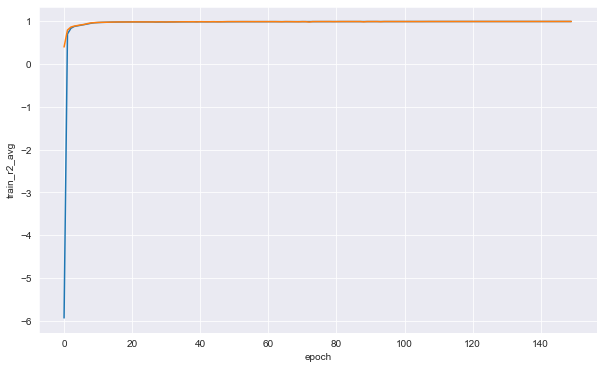

In [13]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(150)
result_pd['train_r2_avg'] = train_r2
result_pd['val_r2_avg'] = val_r2

loop.plot_line_2(y_1='train_r2_avg', y_2='val_r2_avg', df=result_pd, fig_size=(10, 6), output_path="D:\\PythonProject\\RebuildProject\\Rock\\imgs\\MRCk2_MDN20231129_TrainValR2.png", dpi=300)

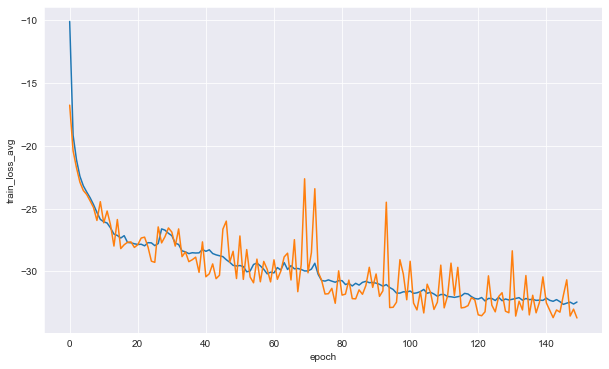

In [14]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(150)
result_pd['train_loss_avg'] = t_l
result_pd['val_loss_avg'] = v_l

loop.plot_line_2(y_1='train_loss_avg', y_2='val_loss_avg', df=result_pd, fig_size=(10, 6), output_path="D:\\PythonProject\\RebuildProject\\Rock\\imgs\\MRCk2_MDN20231129_TrainValLoss.png", dpi=300)

In [16]:
test_x_np = test_x.numpy()
test_y_np = test_y.numpy()

In [17]:
np.save('D:\\Resource\\MDN\\TestDataMRCk2\\test_x.npy', test_x_np)
np.save('D:\\Resource\\MDN\\TestDataMRCk2\\test_y.npy', test_y_np)
np.save('D:\\Resource\\MDN\\TestDataMRCk2\\scaler_x.npy', s_x)
np.save('D:\\Resource\\MDN\\TestDataMRCk2\\scaler_y.npy', s_y)

In [7]:
test_x = np.load("D:\\Resource\\MDN\\TestDataMRCk2\\test_x.npy")
test_y = np.load("D:\\Resource\\MDN\\TestDataMRCk2\\test_y.npy")

In [8]:
model = mdn_advance(len(input_parameters), len(output_parameters), 10, 256)
init_weights(model)
model = nn.DataParallel(model)
model.to("cuda")
model.load_state_dict(torch.load("D:\\Resource\\MDN\\model_best_mdn_0.9951_-34_0.0002.pth"))

<All keys matched successfully>

In [9]:
model.eval()
# Predict
pi, mu, sigma = model(torch.from_numpy(test_x))

# Construct Distribution Function
normal, pi_idx, mu_selected, sigma_selected = pdf(pi, mu, sigma, 'test')

In [21]:
samples = normal.sample()

In [28]:
sample = samples.cpu().numpy()

<Figure size 720x720 with 0 Axes>

In [43]:
fig = plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

E:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


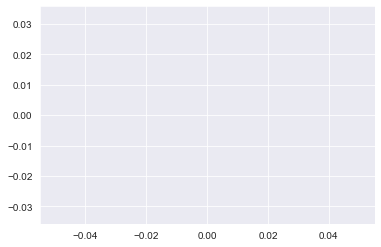

In [30]:
"""
    Plot Scatter
"""
for i in range(len(output_parameters)):
    x = sample[:, i]
    y = test_y[:, i]

    y_max_2 = max(y)
    y_min_2 = min(y)

    ax = fig.add_subplot(3, 3, i + 1)

    ax.scatter(x, y, alpha=0.7, s=10)

    ax.plot([y_min_2, y_max_2], [y_min_2, y_max_2], c='cornflowerblue', ls='--')
    plt.axis('equal')
    ax.set_xlim(y_min_2, y_max_2)
    ax.set_ylim(y_min_2, y_max_2)
    ax.set_title(output_parameters[i])

# plt.show()

NameError: name 'np' is not defined

E:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


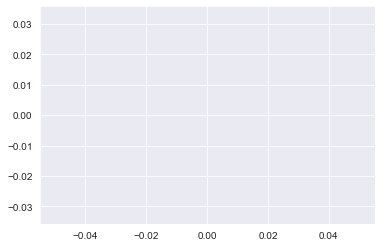

In [46]:
x = sample[:, 0]
y = test_y_np[:, 0]

y_max_2 = max(y)
y_min_2 = min(y)

ax = fig.add_subplot(2, 2, 0 + 1)

# ax.scatter(x, y, alpha=0.7, s=10)

ax.plot([y_min_2, y_max_2], [y_min_2, y_max_2], c='cornflowerblue', ls='--')
plt.axis('equal')
ax.set_xlim(y_min_2, y_max_2)
ax.set_ylim(y_min_2, y_max_2)
ax.set_title(output_parameters[0])


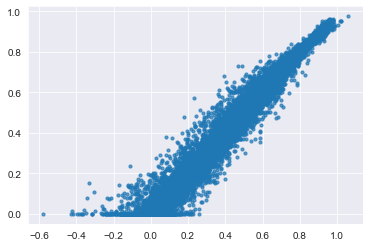

In [45]:
plt.scatter(x, y, alpha=0.7, s=10)

In [39]:
joblib.dump(s_x, "D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_Xscaler_20231201.save")
joblib.dump(s_y, "D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_yscaler_20231201.save")

['D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_yscaler_20231201.save']

In [10]:
mu_np = mu.detach().cpu().numpy()
sigma_np = sigma.detach().cpu().numpy()
pi_np = pi.detach().cpu().numpy()

In [15]:
xlabels = [
    "Actual water radial fraction","Actual mantle radial fraction", "Actual core radial fraction",
    "Actual core mass fraction", "Actual CMB pressure (GPa)", "Actual CMB temperature (K)"
]
ylabels = [
    "Predicted water radial fraction","Predicted mantle radial fraction", "Predicted core radial fraction",
    "Predicted core mass fraction", "Predicted CMB pressure (GPa)", "Predicted CMB temperature (K)"
]
xlocators = [
    0.02, 0.1, 0.1, 0.1, 200, 500
]
xminorlocators = [
    0.005, 0.02, 0.02, 0.02, 50, 100
]

In [55]:
y_label = np.arange(0,1,0.01).reshape(-1,1)
y_label_ = y_label[:, np.newaxis, np.newaxis, :]

In [14]:
fig, axs = pplt.subplots(
    nrows=2, ncols=3,
    share=False,
#     tight=True,
)
for img_num in range(len(output_parameters)):
    y_max = max(test_y[:, img_num])
    y_min = min(test_y[:, img_num])
    for c in range(len(test_y)):
        for m in range(len(output_parameters)):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(10):
                locals()['mus'+str(m)].append(mu_np[c, n, m])
                locals()['sigs'+str(m)].append(sigma_np[c, n, m])


        i = img_num
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pi_np[0]*factors*exponent, axis=1); # 对多个高斯分布求和
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [test_y[c,i],y_min]
        axs[img_num].imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap,
            norm=norm,
            origin='lower',
            extent=(tx, tx + 0.001, ty, y_max)
        )
    axs[img_num].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[img_num].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max),
        xlabel=xlabels[img_num], ylabel=ylabels[img_num],
        xlocator=xlocators[img_num], xminorlocator=xminorlocators[img_num]
    )

In [10]:
for c in range(len(test_y)):
    for m in range(len(output_parameters)):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
        for n in range(10):
            locals()['mus'+str(m)].append(mu_np[c, n, m])
            locals()['sigs'+str(m)].append(sigma_np[c, n, m])
    i = 0
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pi_np[0]*factors*exponent, axis=1); # 对多个高斯分布求和

    break

NameError: name 'mu_np' is not defined

In [9]:
mus_ = np.array(locals()['mus'+str(0)])
sigs_ = np.array(locals()['sigs'+str(0)])

KeyError: 'mus0'

In [67]:
# sub_idx = np.random.choice(mu_np.shape[0], size=87142, replace=False)
mu_sub = mu_np[:40000, :]
sigma_sub = sigma_np[:40000, :]

mu_sub_T = np.transpose(mu_sub, (0, 2, 1))
sigma_sub_T = np.transpose(sigma_sub, (0, 2, 1))

In [68]:
# shape(1000, 6, 100, 10) 1000 data, 6 type, 100 rows with 10 columns every type
exponent_test = np.exp(-1/2*np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3))/sigma_sub_T[:, :, np.newaxis, :]))
factors_test = 1 / math.sqrt(2*math.pi) / sigma_sub_T[:, :, np.newaxis, :]
GMM_PDF_test = np.sum(pi_np[0]*factors_test*exponent_test, axis=-1)
MM = MinMaxScaler()
GMM_PDF_test = GMM_PDF_test.reshape(GMM_PDF_test.shape[0] * GMM_PDF_test.shape[1], GMM_PDF_test.shape[-1]).transpose((-1, 0))
# f = e.transpose((-1, 0))
GMM_PDF_test_scaled = MM.fit_transform(GMM_PDF_test)


In [26]:
del GMM_PDF_test

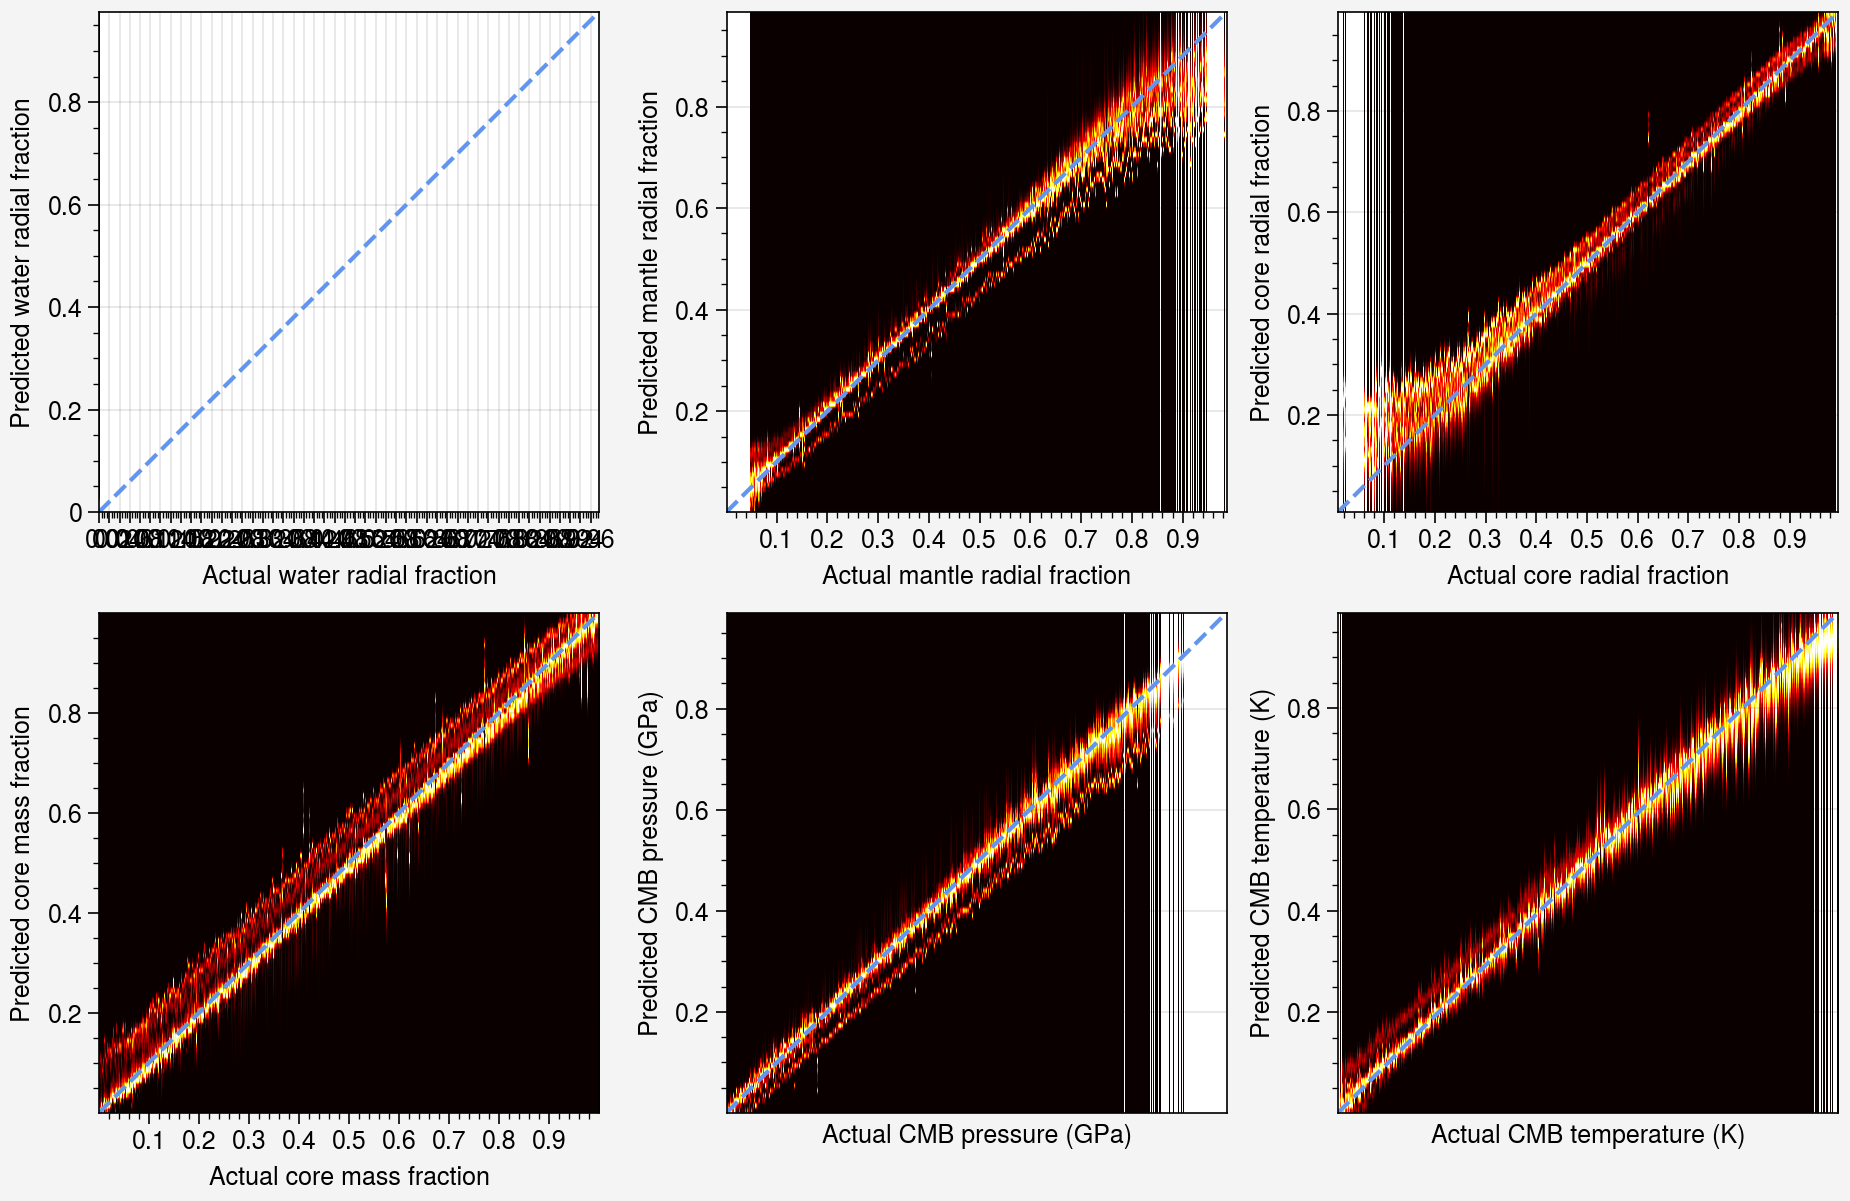

In [27]:
# fig = plt.figure(figsize=(10,10))
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
    nrows=2, ncols=3,
    share=False,
#     tight=True,
)
output_dim = len(output_parameters)

for o in range(output_dim):
    y_max = max(test_y[:, o])
    y_min = min(test_y[:, o])
    # ax = fig.add_subplot(2, 2, o+1)
    for i in range(0, GMM_PDF_test_scaled.shape[-1], 6):
        g = GMM_PDF_test_scaled[:, o + i]
        tx, ty = [test_y[int(i / 6), o], y_min]
        axs[o].imshow(
                g.reshape(-1, 1),
                cmap=cmap,
                norm=norm,
                origin='lower',
                extent=(tx, tx + 0.001, ty, y_max)
            )

    axs[o].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[o].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max),
        xlabel=xlabels[o], ylabel=ylabels[o],
        xlocator=xlocators[o], xminorlocator=xminorlocators[o]
    )

In [49]:
fig.save('D:\\PythonProject\\RebuildProject\\Rock\\imgs\\prediction_MRCk2_20231201.png')

KeyboardInterrupt: 

In [11]:
test_y_inverse = s_y.inverse_transform(test_y)
# test_y_inverse = test_y_inverse[:40000, :]
# test_y_sub = test_y[:40000, :]

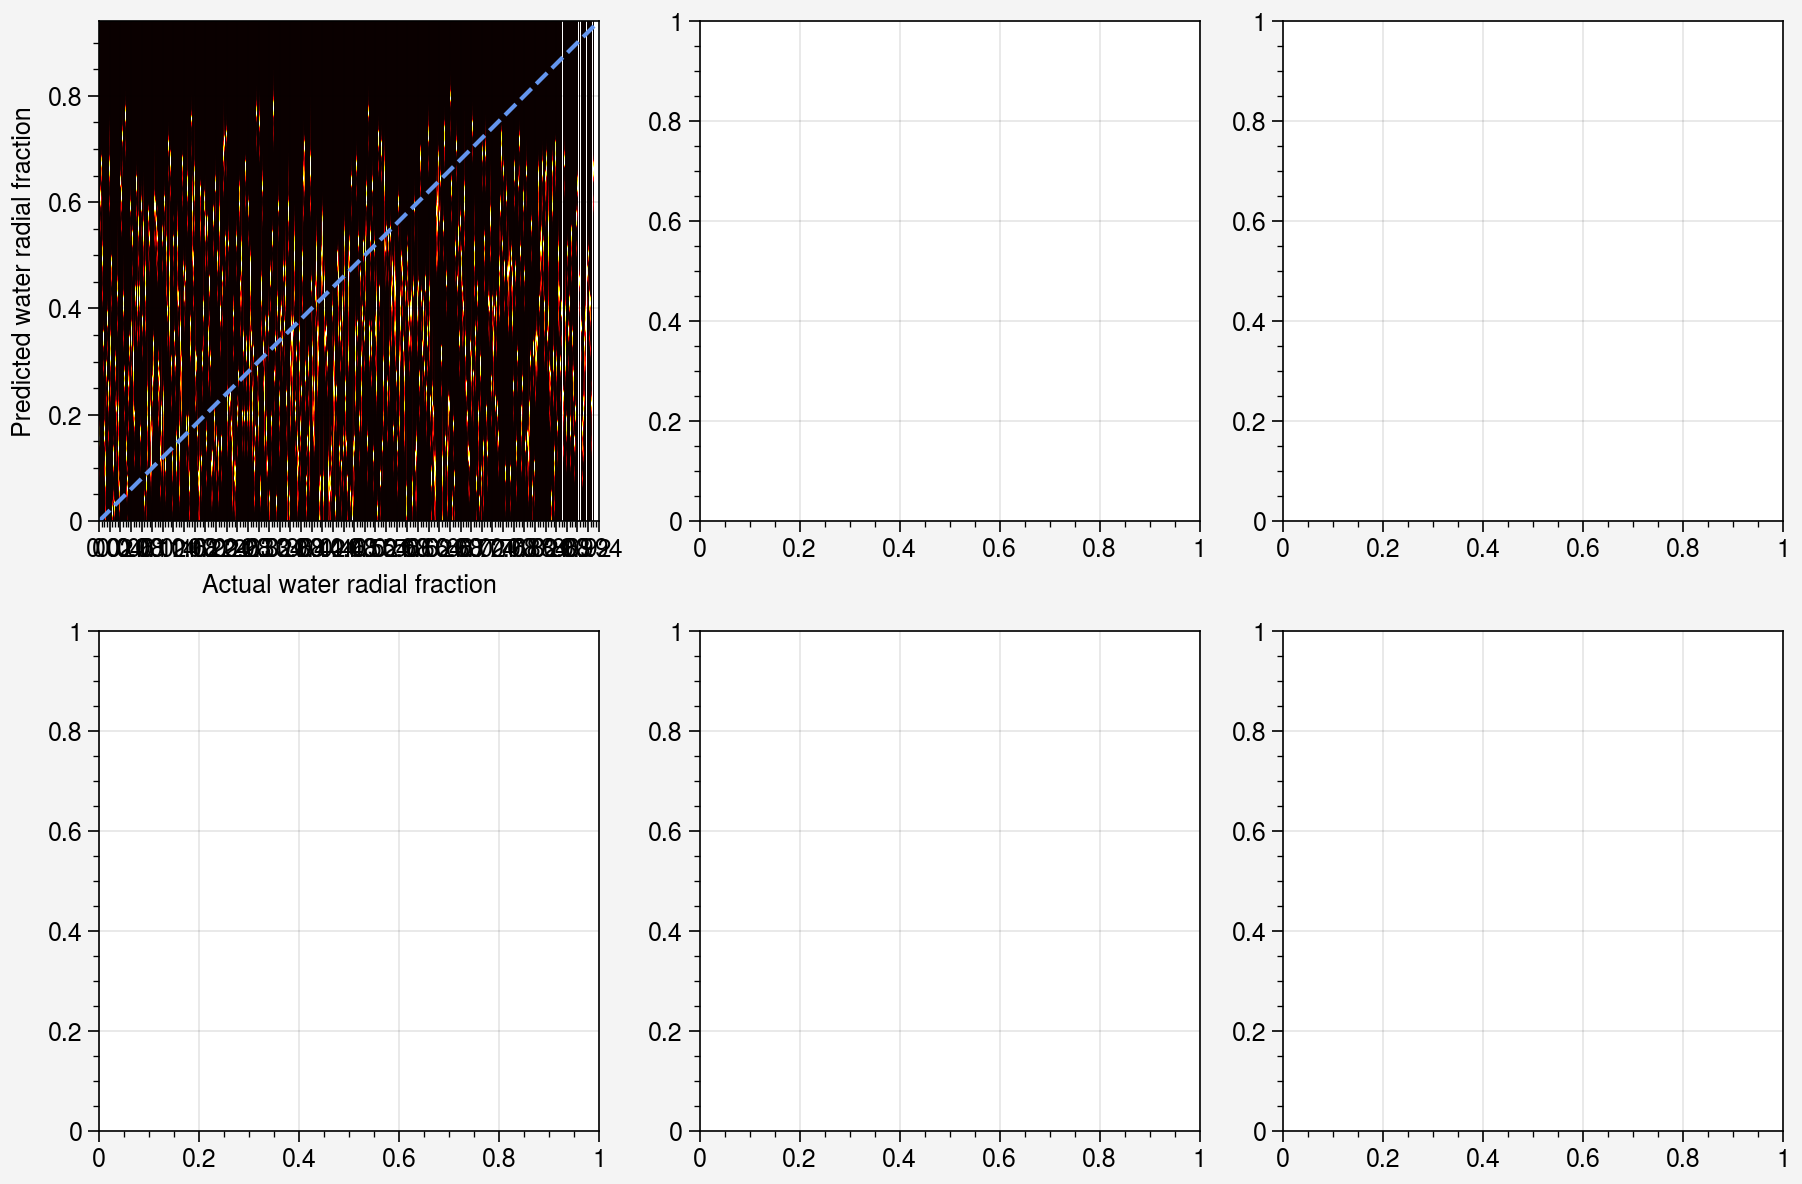

In [71]:
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
    nrows=2, ncols=3,
    share=False,
#     tight=True,
)
# fig = plt.figure(figsize=(10,10))

y_max = max(test_y_sub[:, 0])
y_min = min(test_y_sub[:, 0])
# ax = fig.add_subplot(2, 2, 0+1)
for i in range(0, GMM_PDF_test_scaled.shape[-1], 6):
    g = GMM_PDF_test_scaled[:, 0 + i]
    tx, ty = [test_y_sub[int(i / 6), 0], y_min]
    axs[0].imshow(
                g.reshape(-1, 1),
                cmap=cmap,
                norm=norm,
                origin='lower',
                extent=(tx, tx + 0.001, ty, y_max)
            )

axs[0].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
axs[0].format(
    xlim=(y_min, y_max), ylim=(y_min, y_max),
    xlabel=xlabels[0], ylabel=ylabels[0],
    xlocator=xlocators[0], xminorlocator=xminorlocators[0]
)

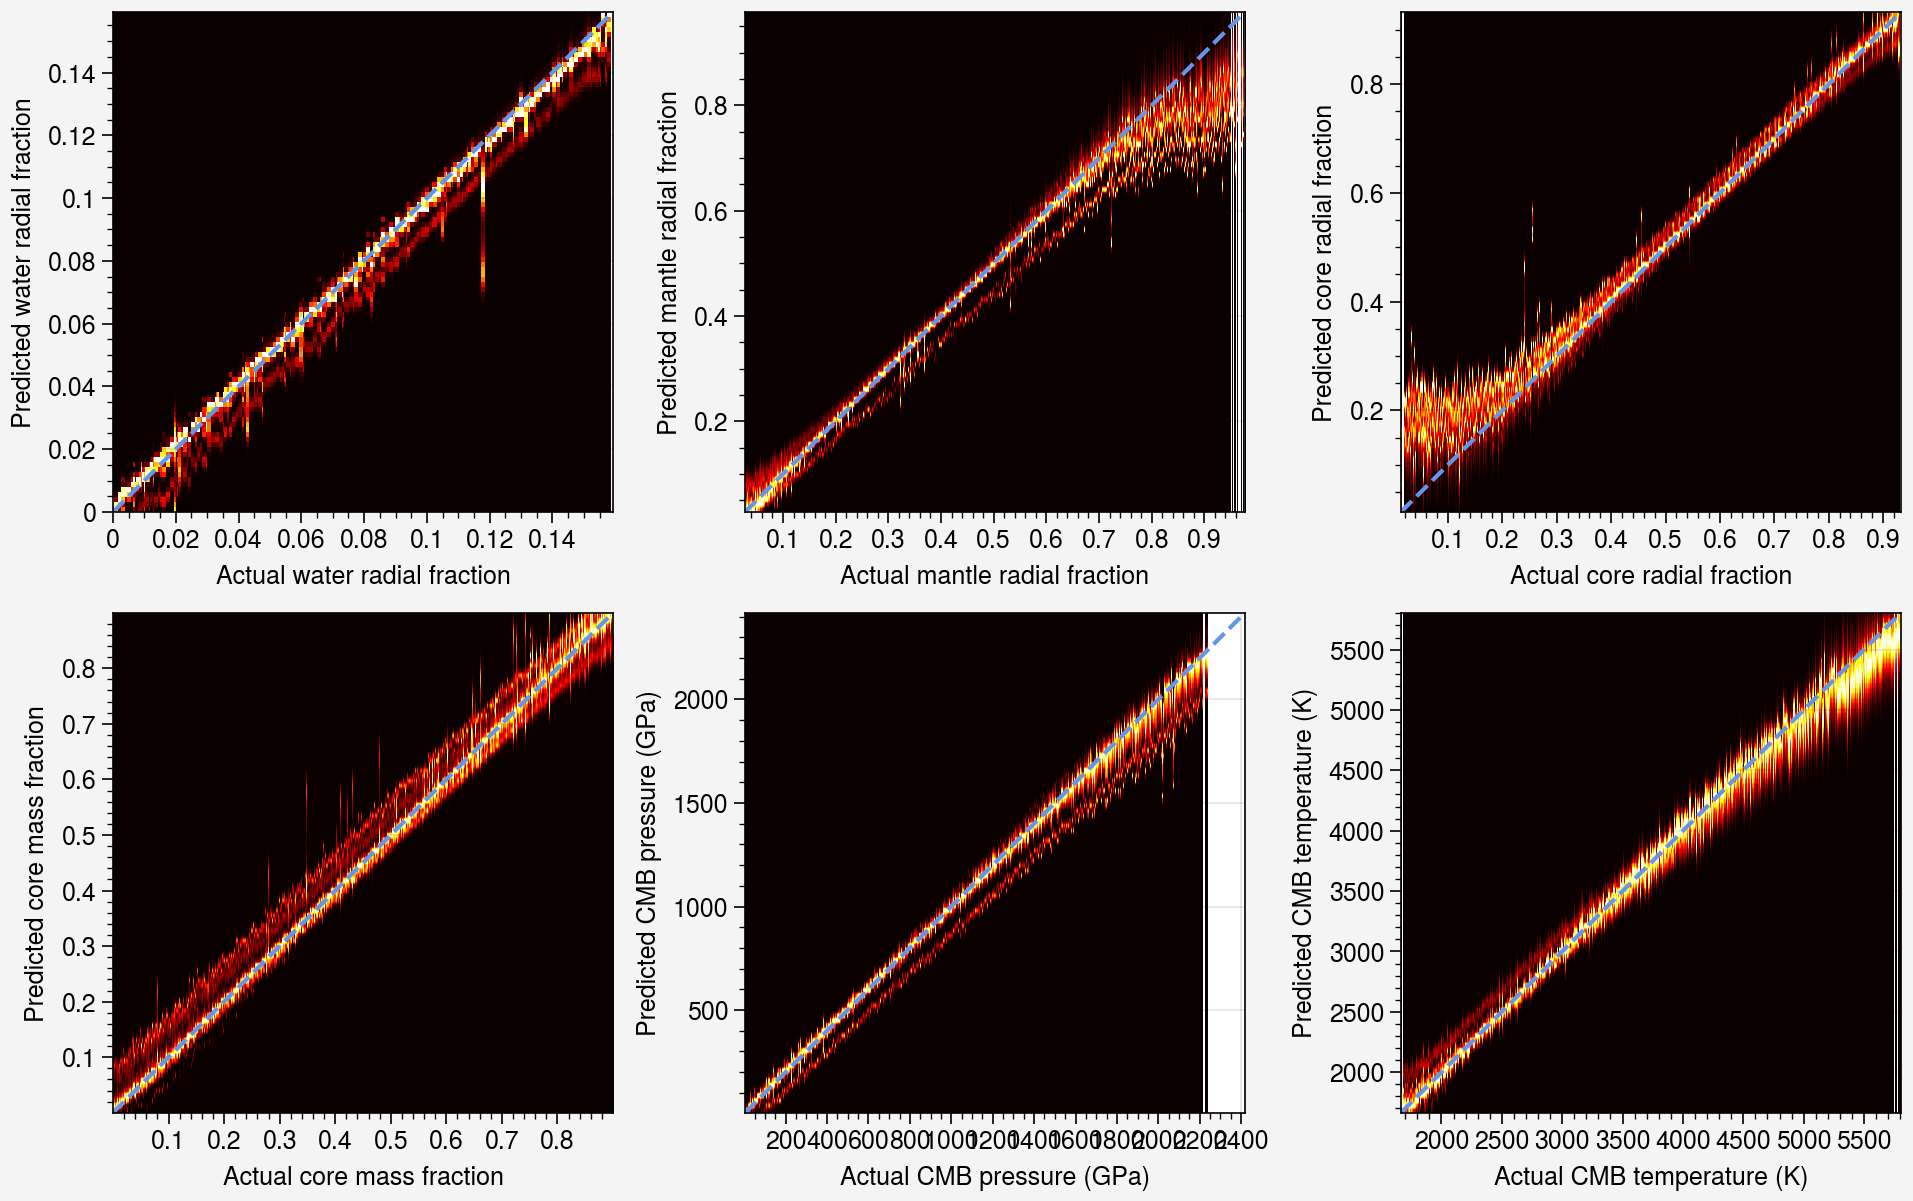

In [12]:
# pred = model.predict(X_test_scaled_pre)
# pred contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters
mus = mu_np.reshape(mu_np.shape[0], mu_np.shape[1] * mu_np.shape[-1])
sigs = sigma_np.reshape(sigma_np.shape[0], sigma_np.shape[1] * sigma_np.shape[-1])
pis = pi_np

y_label = np.arange(0,1,0.01).reshape(-1,1)
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
    nrows=2, ncols=3,
    share=False,
#     tight=True,
)
xlabels = [
    "Actual water radial fraction","Actual mantle radial fraction", "Actual core radial fraction",
    "Actual core mass fraction", "Actual CMB pressure (GPa)", "Actual CMB temperature (K)"
]
ylabels = [
    "Predicted water radial fraction","Predicted mantle radial fraction", "Predicted core radial fraction",
    "Predicted core mass fraction", "Predicted CMB pressure (GPa)", "Predicted CMB temperature (K)"
]

xlocators = [
    0.02, 0.1, 0.1, 0.1, 200, 500
]
xminorlocators = [
    0.005, 0.02, 0.02, 0.02, 50, 100
]
OUTPUT_DIMS = len(output_parameters)
# sendmessage('start plotting')

for img_num in range(OUTPUT_DIMS):
    y_max = max(test_y_inverse[:, img_num])
    y_min = min(test_y_inverse[:, img_num])
    for c in range(len(test_y_inverse)):
        for m in range(OUTPUT_DIMS):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(10):
                locals()['mus'+str(m)].append(mus[c][n*OUTPUT_DIMS + m])
                locals()['sigs'+str(m)].append(sigs[c][n*OUTPUT_DIMS + m])
        i = img_num
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1) # 对多个高斯分布求和
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [test_y_inverse[c,i],y_min]
        axs[img_num].imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap,
            norm=norm,
            origin='lower',
            extent=(tx, tx + 0.001, ty, y_max)
        )
    axs[img_num].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[img_num].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max),
        xlabel=xlabels[img_num], ylabel=ylabels[img_num],
        xlocator=xlocators[img_num], xminorlocator=xminorlocators[img_num]
    )
# fig.save('prediction_MRCk2_20230503.pdf')
# sendmessage('Drawing is complete')

In [14]:
fig.save('D:\\PythonProject\\RebuildProject\\Rock\\imgs\\prediction_MRCk2_20231201.pdf')

KeyboardInterrupt: 